# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import re

import xgboost

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from tensorflow.keras.preprocessing import text, sequence

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

c:\Users\TheRealGod\anaconda3\envs\Pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [5]:
# sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5)
def emotion(integer):
    emotions = {
        0: 'sadness',
        1: 'joy',
        2: 'love',
        3: 'anger',
        4: 'fear',
        5: 'surprise'
    }
    return emotions[integer]

def emotions(probabilities):
    print("Probabilities:")
    for i, prob in enumerate(probabilities):
        print(f"{emotion(i)}: {prob:.4f}")
    return None

In [6]:
df = pd.read_csv('text.csv')
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [7]:
df.shape

(416809, 3)

In [8]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [9]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [11]:
n_classes = df['label'].nunique()
print(f'Number of classes: {n_classes}')

Number of classes: 6


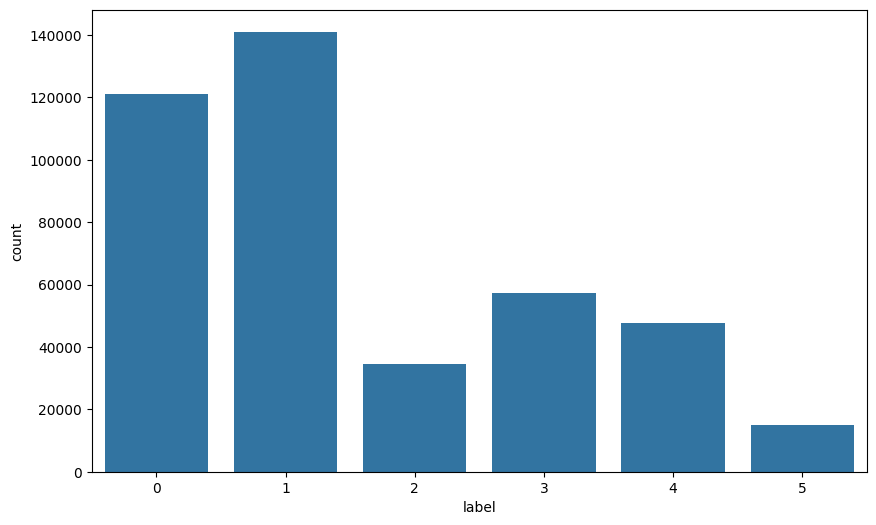

In [12]:
# Plotting the distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.show()

# Preprocessing

# Metric

In [17]:
# accuracy
# multiclass logloss

# Models

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    df['text'], 
    df['label'], 
    test_size=0.2, 
    stratify=df['label'], # Ensuring y (class) distribution is maintained
    random_state=seed,
    shuffle=True)

In [14]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(333447,) (83362,) (333447,) (83362,)


### Model 1: TF-IDF on Logistic Regression

In [48]:
tfidfv = TfidfVectorizer(
    analyzer='word',
    min_df=3, # Minimum document frequency of 3
    max_features=None,
    strip_accents='unicode',
    token_pattern=r'\w{1,}', # Only words with 1 or more characters (number, letter, underscore)
    ngram_range=(1, 2), # Unigrams and bigrams
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True,
    stop_words='english' # Removing common English stop words
)

tfidfv.fit(x_train) # Fit on train only, for consistent vocabulary, and prevent data leakage
x_train_tfidf = tfidfv.transform(x_train)
x_test_tfidf = tfidfv.transform(x_test)

In [49]:
x_train_tfidf.shape, x_test_tfidf.shape

((333447, 142635), (83362, 142635))

In [50]:
TOP_K = 20000
selector = SelectKBest(score_func=f_classif, k=min(TOP_K, x_train_tfidf.shape[1]))
selector.fit(x_train_tfidf, y_train)
x_train_tfidf_selected = selector.transform(x_train_tfidf)
x_test_tfidf_selected = selector.transform(x_test_tfidf)

In [51]:
x_train_tfidf_selected.shape, x_test_tfidf_selected.shape

((333447, 20000), (83362, 20000))

In [52]:
lgr = LogisticRegression(
    C=1.0, # Regularization strength (C is the inverse of regularization strength, smaller values mean stronger regularization)
    max_iter=1000, # Maximum number of iterations for convergence
    ) 
lgr.fit(x_train_tfidf_selected, y_train)

LogisticRegression(max_iter=1000)

In [53]:
print(f'Training accuracy: {lgr.score(x_train_tfidf_selected, y_train):.4f}')
print(f'Test accuracy: {lgr.score(x_test_tfidf_selected, y_test):.4f}')

Training accuracy: 0.9254
Test accuracy: 0.9114


#### without TOP_K

In [26]:
lgr1 = LogisticRegression(
    C=1.0, 
    max_iter=1000, 
    class_weight='balanced' # Handling class imbalance
)
lgr1.fit(x_train_tfidf, y_train)
print(f'Training accuracy with balanced classes: {lgr1.score(x_train_tfidf, y_train):.4f}')
print(f'Test accuracy with balanced classes: {lgr1.score(x_test_tfidf, y_test):.4f}')

Training accuracy with balanced classes: 0.9297
Test accuracy with balanced classes: 0.9057


#### with TOP_K, GridSearch

In [30]:
lgr2 = LogisticRegression(
    C=1.0, 
    max_iter=1000, 
    class_weight='balanced', 
    penalty='l2',
    solver='lbfgs',
)
param_grid = {
    'C': [0.1, 1, 10], # Regularization strength
    'penalty': ['l2'],
    'solver': ['lbfgs'], # corresponds to elasticnet penalty
}
grid_search = GridSearchCV(
    lgr2, 
    param_grid, 
    scoring='accuracy', 
    cv=5, # 5-fold cross-validation
    verbose=1, 
    n_jobs=10
)
grid_search.fit(x_train_tfidf_selected, y_train)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_:.4f}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.9132


In [31]:
lgr2_best = grid_search.best_estimator_
print(f'Test accuracy with best parameters: {lgr2_best.score(x_test_tfidf_selected, y_test):.4f}')

Test accuracy with best parameters: 0.9120


#### Simple testing

In [ ]:
# test = ["Do not do that, that is not nice"]
# test_tfidf = tfidfv.transform(test)
# test_tfidf_selected = selector.transform(test_tfidf)
# predicted = lgr.predict(test_tfidf_selected)
# probabilities = lgr.predict_proba(test_tfidf_selected)
# emotions(probabilities[0])

Probabilities:
sadness: 0.2167
joy: 0.4348
love: 0.0690
anger: 0.1780
fear: 0.0822
surprise: 0.0192


### Model 2: TF-IDF on Multi-Layer Perceptrons (MLP)

In [54]:
class SimpleMLP(nn.Module):
    """
    Fixed‑shape MLP: one hidden layer + softmax output (6 classes).
    Dropout before every Linear.
    """
    def __init__(self, input_dim: int, hidden_units: int = 128, dropout_rate: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Dropout(dropout_rate),            # input dropout
            nn.Linear(input_dim, hidden_units),  
            nn.ReLU(inplace=True),               # non-linearity before regularization
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units, 6),          # 6‑class output
            # nn.Softmax(dim=1)                    # softmax activation (multiclass)
        )

    def forward(self, x):
        return self.net(x)

In [55]:
svd = TruncatedSVD(n_components=300, random_state=42)
x_train_reduced = svd.fit_transform(x_train_tfidf_selected)  # shape: (333447, 300)
x_test_reduced = svd.transform(x_test_tfidf_selected)  # shape: (83362, 300)
x_train_tensor = torch.tensor(x_train_reduced, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_reduced, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [56]:
simpleMLP = SimpleMLP(input_dim=x_train_reduced.shape[1]).to(device)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simpleMLP.parameters(), lr=0.005)

num_epochs = 20
simpleMLP.train()

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = simpleMLP(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/total:.4f}, Accuracy: {correct/total:.4f}')
        

  5%|▌         | 1/20 [00:04<01:19,  4.17s/it]

Epoch [1/20], Loss: 0.6367, Accuracy: 0.7650


 10%|█         | 2/20 [00:07<01:09,  3.88s/it]

Epoch [2/20], Loss: 0.4992, Accuracy: 0.8140


 15%|█▌        | 3/20 [00:11<01:05,  3.85s/it]

Epoch [3/20], Loss: 0.4708, Accuracy: 0.8235


 20%|██        | 4/20 [00:15<01:00,  3.80s/it]

Epoch [4/20], Loss: 0.4581, Accuracy: 0.8285


 25%|██▌       | 5/20 [00:19<00:56,  3.79s/it]

Epoch [5/20], Loss: 0.4484, Accuracy: 0.8315


 30%|███       | 6/20 [00:23<00:53,  3.86s/it]

Epoch [6/20], Loss: 0.4430, Accuracy: 0.8338


 35%|███▌      | 7/20 [00:27<00:50,  3.90s/it]

Epoch [7/20], Loss: 0.4399, Accuracy: 0.8342


 40%|████      | 8/20 [00:31<00:48,  4.04s/it]

Epoch [8/20], Loss: 0.4355, Accuracy: 0.8361


 45%|████▌     | 9/20 [00:35<00:45,  4.11s/it]

Epoch [9/20], Loss: 0.4321, Accuracy: 0.8371


 50%|█████     | 10/20 [00:39<00:41,  4.11s/it]

Epoch [10/20], Loss: 0.4295, Accuracy: 0.8375


 55%|█████▌    | 11/20 [00:44<00:37,  4.14s/it]

Epoch [11/20], Loss: 0.4277, Accuracy: 0.8393


 60%|██████    | 12/20 [00:47<00:32,  4.06s/it]

Epoch [12/20], Loss: 0.4249, Accuracy: 0.8394


 65%|██████▌   | 13/20 [00:51<00:27,  3.94s/it]

Epoch [13/20], Loss: 0.4242, Accuracy: 0.8402


 70%|███████   | 14/20 [00:55<00:23,  3.88s/it]

Epoch [14/20], Loss: 0.4220, Accuracy: 0.8409


 75%|███████▌  | 15/20 [00:58<00:18,  3.80s/it]

Epoch [15/20], Loss: 0.4215, Accuracy: 0.8414


 80%|████████  | 16/20 [01:02<00:15,  3.77s/it]

Epoch [16/20], Loss: 0.4203, Accuracy: 0.8416


 85%|████████▌ | 17/20 [01:06<00:11,  3.76s/it]

Epoch [17/20], Loss: 0.4184, Accuracy: 0.8416


 90%|█████████ | 18/20 [01:10<00:07,  3.72s/it]

Epoch [18/20], Loss: 0.4190, Accuracy: 0.8421


 95%|█████████▌| 19/20 [01:13<00:03,  3.72s/it]

Epoch [19/20], Loss: 0.4165, Accuracy: 0.8434


100%|██████████| 20/20 [01:17<00:00,  3.87s/it]

Epoch [20/20], Loss: 0.4166, Accuracy: 0.8429


In [58]:
# Evaluation on the test set
simpleMLP.eval()
total_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = simpleMLP(inputs)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Loss: {total_loss/total:.4f}, Test Accuracy: {correct/total:.4f}')

Test Loss: 0.3483, Test Accuracy: 0.8636


### Model 3: N-gram (CountVectorizer) on Logistic Regression

In [66]:
cv = CountVectorizer(
    analyzer='word',
    token_pattern=r'\w{1,}',  # Only words with 1 or more characters (number, letter, underscore)
    ngram_range=(1, 2),  # Unigrams and bigrams
    stop_words='english'  # Removing common English stop words
)

cv.fit(x_train)  # Fit on train only
x_train_cv = cv.transform(x_train)
x_test_cv = cv.transform(x_test)

In [67]:
TOP_K = 20000
selector_cv = SelectKBest(score_func=f_classif, k=min(TOP_K, x_train_cv.shape[1]))
selector_cv.fit(x_train_cv, y_train)
x_train_cv_selected = selector_cv.transform(x_train_cv)
x_test_cv_selected = selector_cv.transform(x_test_cv)

In [41]:
lr2 = LogisticRegression(
    C=1.0,  # Regularization strength
    max_iter=1000,  # Maximum number of iterations for convergence
)
lr2.fit(x_train_cv_selected, y_train)

LogisticRegression(max_iter=1000)

In [42]:
print(f'Training accuracy (CountVectorizer): {lr2.score(x_train_cv_selected, y_train):.4f}')
print(f'Test accuracy (CountVectorizer): {lr2.score(x_test_cv_selected, y_test):.4f}')

Training accuracy (CountVectorizer): 0.9313
Test accuracy (CountVectorizer): 0.9078


#### without TOP_K

In [43]:
lr3 = LogisticRegression(
    C=1.0,  # Regularization strength
    max_iter=1000,  # Maximum number of iterations for convergence
)
lr3.fit(x_train_cv, y_train)

LogisticRegression(max_iter=1000)

In [44]:
print(f'Training accuracy (CountVectorizer without feature selection): {lr3.score(x_train_cv, y_train):.4f}')
print(f'Test accuracy (CountVectorizer without feature selection): {lr3.score(x_test_cv, y_test):.4f}')

Training accuracy (CountVectorizer without feature selection): 0.9545
Test accuracy (CountVectorizer without feature selection): 0.8814


### Model 4: TF-IDF on Naive Bayes

In [59]:
nb = MultinomialNB()
nb.fit(x_train_tfidf_selected, y_train)

MultinomialNB()

In [60]:
print(f'Training accuracy (MultinomialNB): {nb.score(x_train_tfidf_selected, y_train):.4f}')
print(f'Test accuracy (MultinomialNB): {nb.score(x_test_tfidf_selected, y_test):.4f}')

Training accuracy (MultinomialNB): 0.8842
Test accuracy (MultinomialNB): 0.8722


#### without TOP_K

In [61]:
nb2 = MultinomialNB()
nb2.fit(x_train_tfidf, y_train)

MultinomialNB()

In [62]:
print(f'Training accuracy (MultinomialNB without feature selection): {nb2.score(x_train_tfidf, y_train):.4f}')
print(f'Test accuracy (MultinomialNB without feature selection): {nb2.score(x_test_tfidf, y_test):.4f}')

Training accuracy (MultinomialNB without feature selection): 0.8724
Test accuracy (MultinomialNB without feature selection): 0.8330


#### with TOP_K, GridSearch

In [63]:
nb5 = MultinomialNB()
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 5.0, 10.0],  # Smoothing parameter
    'fit_prior': [True, False]  # Whether to learn class prior from data, if False, class prior is 0.5
}
grid = GridSearchCV(
    estimator=nb5,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
)
grid.fit(x_train_tfidf_selected, y_train)
print(f'Best parameters: {grid.best_params_}')
print(f'Best cross-validation accuracy: {grid.best_score_:.4f}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'alpha': 1.0, 'fit_prior': False}
Best cross-validation accuracy: 0.9115


In [64]:
nb5_best = grid.best_estimator_
print(f'Test accuracy with best parameters: {nb5_best.score(x_test_tfidf_selected, y_test):.4f}')

Test accuracy with best parameters: 0.9068


### Model 5: N-gram on Naive Bayes

In [68]:
nb3 = MultinomialNB()
nb3.fit(x_train_cv_selected, y_train)

MultinomialNB()

In [69]:
print(f'Training accuracy (MultinomialNB with CountVectorizer): {nb3.score(x_train_cv_selected, y_train):.4f}')
print(f'Test accuracy (MultinomialNB with CountVectorizer): {nb3.score(x_test_cv_selected, y_test):.4f}')

Training accuracy (MultinomialNB with CountVectorizer): 0.9203
Test accuracy (MultinomialNB with CountVectorizer): 0.9088


#### without TOP_K

In [70]:
nb4 = MultinomialNB()
nb4.fit(x_train_cv, y_train)

MultinomialNB()

In [71]:
print(f'Training accuracy (MultinomialNB with CountVectorizer without feature selection): {nb4.score(x_train_cv, y_train):.4f}')
print(f'Test accuracy (MultinomialNB with CountVectorizer without feature selection): {nb4.score(x_test_cv, y_test):.4f}')

Training accuracy (MultinomialNB with CountVectorizer without feature selection): 0.9263
Test accuracy (MultinomialNB with CountVectorizer without feature selection): 0.8226


#### With TOP_K, GridSearch

In [72]:
nb6 = MultinomialNB()
param_grid_nb = {
    'alpha': [0.01, 0.1, 1.0, 5.0, 10.0],  # Smoothing parameter
    'fit_prior': [True, False]  # Whether to learn class prior from data, if False, class prior is 0.5
}
grid_nb = GridSearchCV(
    estimator=nb6,
    param_grid=param_grid_nb,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
)
grid_nb.fit(x_train_cv_selected, y_train)
print(f'Best parameters (CountVectorizer NB): {grid_nb.best_params_}')
print(f'Best cross-validation accuracy (CountVectorizer NB): {grid_nb.best_score_:.4f}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters (CountVectorizer NB): {'alpha': 1.0, 'fit_prior': True}
Best cross-validation accuracy (CountVectorizer NB): 0.9150


In [73]:
nb6_best = grid_nb.best_estimator_
print(f'Test accuracy with best parameters (CountVectorizer NB): {nb6_best.score(x_test_cv_selected, y_test):.4f}')

Test accuracy with best parameters (CountVectorizer NB): 0.9088


### Model 6: TF-IDF on XGBoost

In [57]:
xgb = xgboost.XGBClassifier(
    max_depth = 7,
    n_estimators = 100, # Number of trees to build
    colsample_bytree = 0.8, # use 80% of columns (features) for each tree
    subsample = 0.8, # use 80% of samples (rows) for each tree
    n_jobs = -1, # use all available CPU cores
    learning_rate = 0.1,
)
xgb.fit(x_train_tfidf_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

In [58]:
print(f'Training accuracy (XGBoost): {xgb.score(x_train_tfidf_selected, y_train):.4f}')
print(f'Test accuracy (XGBoost): {xgb.score(x_test_tfidf_selected, y_test):.4f}')

Training accuracy (XGBoost): 0.8848
Test accuracy (XGBoost): 0.8760


#### 200 estimators

In [ ]:
xgb2 = xgboost.XGBClassifier(
    max_depth = 7,
    n_estimators = 200, # Number of trees to build
    colsample_bytree = 0.8, # use 80% of columns (features) for each tree
    subsample = 0.8, # use 80% of samples (rows) for each tree
    n_jobs = -1, # use all available CPU cores
    learning_rate = 0.1,
)
xgb2.fit(x_train_tfidf_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
print(f'Training accuracy (XGBoost with more trees): {xgb2.score(x_train_tfidf_selected, y_train):.4f}')
print(f'Test accuracy (XGBoost with more trees): {xgb2.score(x_test_tfidf_selected, y_test):.4f}')

Training accuracy (XGBoost with more trees): 0.9063
Test accuracy (XGBoost with more trees): 0.8914


### Model 7: Sentence GloVe on Logistic Regression

#### Source of Pretrained GloVe
https://github.com/stanfordnlp/GloVe<br>
840B tokens

In [15]:
glove_dict = {}

with open('..\glove.840B.300d\glove.840B.300d.txt', 'r', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = values[1:]
        
        if len(vector) != 300: # ignore lines that do not have exactly 300 dimensions
            continue

        vector = np.array(vector, dtype=np.float32)
        glove_dict[word] = vector

print(f'Loaded {len(glove_dict)} words from GloVe embeddings.')

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\TheRealGod\AppData\Local\Temp\ipykernel_56708\2402125379.py:3: SyntaxWarning: invalid escape sequence '\g'
  with open('..\glove.840B.300d\glove.840B.300d.txt', 'r', encoding='utf-8') as f:
2196018it [01:28, 24829.95it/s]

Loaded 2195876 words from GloVe embeddings.


In [16]:
def tokenzie(text):
    return re.findall(r'\b\w+\b', text.lower())

def sentence_to_glove(sentence):
    tokens = tokenzie(sentence)
    M = []
    
    for token in tokens:
        if token in glove_dict:
            M.append(glove_dict[token])
    
    if not M:
        return np.zeros(300, dtype=np.float32)  # Return zero vector if no tokens found
    
    M = np.array(M)
    v = M.sum(axis=0)  # Sum the vectors
    l2 = np.linalg.norm(v)  # Compute L2 norm
    v /= l2  # Normalize the vector
    return v

In [17]:
x_train_glove = [sentence_to_glove(sentence) for sentence in tqdm(x_train)]
x_test_glove = [sentence_to_glove(sentence) for sentence in tqdm(x_test)]

100%|██████████| 83362/83362 [00:01<00:00, 66814.18it/s]


In [18]:
lr4 = LogisticRegression(
    C=1.0,  # Regularization strength
    max_iter=1000,  # Maximum number of iterations for convergence
)
lr4.fit(x_train_glove, y_train)

LogisticRegression(max_iter=1000)

In [19]:
print(f'Training accuracy (GloVe embeddings): {lr4.score(x_train_glove, y_train):.4f}')
print(f'Test accuracy (GloVe embeddings): {lr4.score(x_test_glove, y_test):.4f}')

Training accuracy (GloVe embeddings): 0.7166
Test accuracy (GloVe embeddings): 0.7146


#### with StandardScaler

In [73]:
scaler = StandardScaler()
x_train_glove_scaled = scaler.fit_transform(x_train_glove)
x_test_glove_scaled = scaler.transform(x_test_glove)

In [74]:
lr5 = LogisticRegression(
    C=1.0,  # Regularization strength
    max_iter=1000,  # Maximum number of iterations for convergence
)
lr5.fit(x_train_glove_scaled, y_train)

LogisticRegression(max_iter=1000)

In [75]:
print(f'Training accuracy (GloVe embeddings scaled): {lr5.score(x_train_glove_scaled, y_train):.4f}')
print(f'Test accuracy (GloVe embeddings scaled): {lr5.score(x_test_glove_scaled, y_test):.4f}')

Training accuracy (GloVe embeddings scaled): 0.7300
Test accuracy (GloVe embeddings scaled): 0.7279


### Model 8: Sentence GloVe on XGBoost

In [70]:
xgb3 = xgboost.XGBClassifier(
    max_depth = 7,
    n_estimators = 100,
    colsample_bytree = 0.8, 
    subsample = 0.8, 
    n_jobs = -1, 
    learning_rate = 0.1,
)
xgb3.fit(x_train_glove, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

In [71]:
print(f'Training accuracy (XGBoost with GloVe embeddings): {xgb3.score(x_train_glove, y_train):.4f}')
print(f'Test accuracy (XGBoost with GloVe embeddings): {xgb3.score(x_test_glove, y_test):.4f}')

Training accuracy (XGBoost with GloVe embeddings): 0.7218
Test accuracy (XGBoost with GloVe embeddings): 0.6598


### Model 9: Sentence GloVe with MLP

In [76]:
class MLP2(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.Linear(300, 300)
        self.dropout1 = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(300)

        self.l2 = nn.Linear(300, 300)
        self.dropout2 = nn.Dropout(0.2)
        self.bn2 = nn.BatchNorm1d(300)

        self.l3 = nn.Linear(300, 6)  # 6 classes
    
    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.bn1(x)

        x = self.l2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.bn2(x)

        x = self.l3(x)
        return F.softmax(x, dim=1)

In [79]:
mlp2 = MLP2().to(device)

In [80]:
x_train_glove_tensor = torch.tensor(x_train_glove_scaled, dtype=torch.float32).to(device)
x_test_glove_tensor = torch.tensor(x_test_glove_scaled, dtype=torch.float32).to(device)
y_train_glove_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_glove_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)
train_dataset_glove = TensorDataset(x_train_glove_tensor, y_train_glove_tensor)
test_dataset_glove = TensorDataset(x_test_glove_tensor, y_test_glove_tensor)
train_loader_glove = DataLoader(train_dataset_glove, batch_size=128, shuffle=True)
test_loader_glove = DataLoader(test_dataset_glove, batch_size=128)

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp2.parameters(), lr=0.001)

num_epochs = 20

mlp2.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader_glove:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mlp2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/total:.4f}, Accuracy: {correct/total:.4f}')

  5%|▌         | 1/20 [00:04<01:34,  4.97s/it]

Epoch [1/20], Loss: 1.2694, Accuracy: 0.7736


 10%|█         | 2/20 [00:09<01:29,  4.95s/it]

Epoch [2/20], Loss: 1.2689, Accuracy: 0.7741


 15%|█▌        | 3/20 [00:14<01:24,  4.99s/it]

Epoch [3/20], Loss: 1.2679, Accuracy: 0.7751


 20%|██        | 4/20 [00:20<01:23,  5.21s/it]

Epoch [4/20], Loss: 1.2671, Accuracy: 0.7759


 25%|██▌       | 5/20 [00:25<01:19,  5.30s/it]

Epoch [5/20], Loss: 1.2666, Accuracy: 0.7764


 30%|███       | 6/20 [00:31<01:14,  5.35s/it]

Epoch [6/20], Loss: 1.2663, Accuracy: 0.7768


 35%|███▌      | 7/20 [00:36<01:08,  5.28s/it]

Epoch [7/20], Loss: 1.2651, Accuracy: 0.7780


 40%|████      | 8/20 [00:41<01:03,  5.32s/it]

Epoch [8/20], Loss: 1.2648, Accuracy: 0.7783


 45%|████▌     | 9/20 [00:46<00:57,  5.22s/it]

Epoch [9/20], Loss: 1.2639, Accuracy: 0.7792


 50%|█████     | 10/20 [00:52<00:51,  5.18s/it]

Epoch [10/20], Loss: 1.2632, Accuracy: 0.7798


 55%|█████▌    | 11/20 [00:56<00:46,  5.11s/it]

Epoch [11/20], Loss: 1.2637, Accuracy: 0.7793


 60%|██████    | 12/20 [01:02<00:40,  5.10s/it]

Epoch [12/20], Loss: 1.2628, Accuracy: 0.7802


 65%|██████▌   | 13/20 [01:07<00:35,  5.13s/it]

Epoch [13/20], Loss: 1.2620, Accuracy: 0.7811


 70%|███████   | 14/20 [01:12<00:30,  5.07s/it]

Epoch [14/20], Loss: 1.2611, Accuracy: 0.7819


 75%|███████▌  | 15/20 [01:17<00:25,  5.07s/it]

Epoch [15/20], Loss: 1.2612, Accuracy: 0.7818


 80%|████████  | 16/20 [01:22<00:20,  5.12s/it]

Epoch [16/20], Loss: 1.2609, Accuracy: 0.7821


 85%|████████▌ | 17/20 [01:27<00:15,  5.09s/it]

Epoch [17/20], Loss: 1.2601, Accuracy: 0.7830


 90%|█████████ | 18/20 [01:32<00:10,  5.07s/it]

Epoch [18/20], Loss: 1.2595, Accuracy: 0.7834


 95%|█████████▌| 19/20 [01:37<00:05,  5.08s/it]

Epoch [19/20], Loss: 1.2598, Accuracy: 0.7832


100%|██████████| 20/20 [01:42<00:00,  5.14s/it]

Epoch [20/20], Loss: 1.2596, Accuracy: 0.7833


In [84]:
# Evaluation on the test set
mlp2.eval()
total_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader_glove:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = mlp2(inputs)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Loss: {total_loss/total:.4f}, Test Accuracy: {correct/total:.4f}')

Test Loss: 1.2617, Test Accuracy: 0.7812


### Model 10: Word GloVe on LSTM

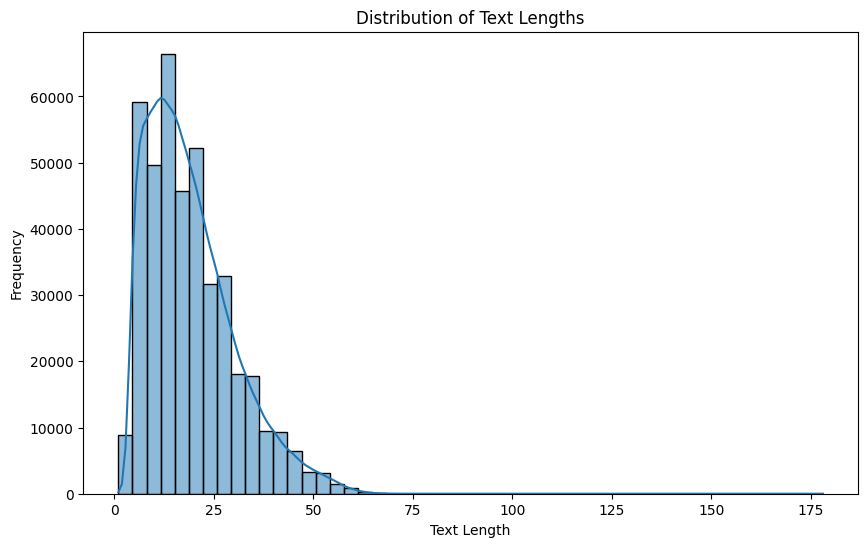

In [20]:
# get the average text length
length = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(length, bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [21]:
token = text.Tokenizer()
max_len = 70

token.fit_on_texts(x_train) # Fit on train only, for consistent vocabulary, and prevent data leakage
x_train_seq = token.texts_to_sequences(x_train)
x_test_seq = token.texts_to_sequences(x_test)

x_train_seq = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_test_seq = sequence.pad_sequences(x_test_seq, maxlen=max_len)

In [22]:
x_train_seq[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,    2,  577,
          3, 6506,   28,  141], dtype=int32)

In [23]:
word_index = token.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 67801 unique tokens.


In [24]:
word_index

{'i': 1,
 'feel': 2,
 'and': 3,
 'to': 4,
 'the': 5,
 'a': 6,
 'feeling': 7,
 'that': 8,
 'of': 9,
 'my': 10,
 'in': 11,
 'it': 12,
 'like': 13,
 'so': 14,
 'for': 15,
 'im': 16,
 'have': 17,
 'me': 18,
 'but': 19,
 'is': 20,
 'was': 21,
 'this': 22,
 'am': 23,
 'with': 24,
 'not': 25,
 'be': 26,
 'about': 27,
 'as': 28,
 'on': 29,
 'you': 30,
 'just': 31,
 'when': 32,
 'at': 33,
 'or': 34,
 'all': 35,
 'because': 36,
 'more': 37,
 'do': 38,
 'can': 39,
 'really': 40,
 'up': 41,
 't': 42,
 'know': 43,
 'by': 44,
 'are': 45,
 'very': 46,
 'been': 47,
 'out': 48,
 'myself': 49,
 'what': 50,
 'if': 51,
 'time': 52,
 'how': 53,
 'get': 54,
 'little': 55,
 'will': 56,
 'had': 57,
 'now': 58,
 'from': 59,
 'people': 60,
 'being': 61,
 'they': 62,
 'would': 63,
 'he': 64,
 'her': 65,
 'want': 66,
 'one': 67,
 'them': 68,
 'think': 69,
 'still': 70,
 'some': 71,
 'ive': 72,
 'even': 73,
 'who': 74,
 'much': 75,
 'an': 76,
 'we': 77,
 'life': 78,
 'him': 79,
 'its': 80,
 'there': 81,
 'somethin

In [25]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))  # +1 for padding token
for word, i in tqdm(word_index.items()):
    if word in glove_dict:
        embedding_matrix[i] = glove_dict[word]

100%|██████████| 67801/67801 [00:00<00:00, 713467.12it/s]


In [26]:
embedding_matrix.shape

(67802, 300)

In [27]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, output_dim=6):
        super().__init__()

        dropout = 0.2
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32), 
            # freeze=True  # Do not finetune embedding
            freeze=False  # Allow finetuning of embedding
        )

        # self.dropout0 = nn.Dropout2d(dropout)  # Spatial dropout for LSTM, drops entire column instead of random positions
        self.dropout0 = nn.Dropout(dropout)

        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            batch_first=True, 
            # dropout=dropout,  # Dropout after LSTM layer
        )

        self.l1 = nn.Linear(hidden_dim, 1024)
        self.dropout1 = nn.Dropout(dropout)

        self.l2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(dropout)

        self.l3 = nn.Linear(1024, output_dim)

    def forward(self, x):
        x = self.embedding(x) # shape (batch_size, seq_len, embedding_dim)

        x = self.dropout0(x)  

        x, _ = self.lstm(x)
        x = x[:, -1, :] # Take the last output of the LSTM, Shape (batch_size, hidden_dim)

        x = self.l1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.l3(x)
        # return F.softmax(x, dim=1)
        return x # cross entropy loss will apply softmax internally


In [28]:
x_train_tensor_lstm = torch.tensor(x_train_seq, dtype=torch.long).to(device)
x_test_tensor_lstm = torch.tensor(x_test_seq, dtype=torch.long).to(device)
y_train_tensor_lstm = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_tensor_lstm = torch.tensor(y_test.values, dtype=torch.long).to(device)
train_dataset_lstm = TensorDataset(x_train_tensor_lstm, y_train_tensor_lstm)
test_dataset_lstm = TensorDataset(x_test_tensor_lstm, y_test_tensor_lstm)
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=128, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=128)

In [29]:
lstm_model = LSTM(embedding_matrix).to(device)

In [30]:
from torchinfo import summary
summary(lstm_model, input_size=(128, max_len), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [128, 6]                  --
├─Embedding: 1-1                         [128, 70, 300]            20,340,600
├─Dropout: 1-2                           [128, 70, 300]            --
├─LSTM: 1-3                              [128, 70, 128]            220,160
├─Linear: 1-4                            [128, 1024]               132,096
├─Dropout: 1-5                           [128, 1024]               --
├─Linear: 1-6                            [128, 1024]               1,049,600
├─Dropout: 1-7                           [128, 1024]               --
├─Linear: 1-8                            [128, 6]                  6,150
Total params: 21,748,606
Trainable params: 21,748,606
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.73
Input size (MB): 0.07
Forward/backward pass size (MB): 32.78
Params size (MB): 86.99
Estimated Total Size (MB): 119.85

 10%|█         | 1/10 [00:12<01:50, 12.26s/it]

Epoch [1/10], Loss: 0.1953, Accuracy: 0.9096


 20%|██        | 2/10 [00:24<01:36, 12.08s/it]

Epoch [2/10], Loss: 0.0910, Accuracy: 0.9417


 30%|███       | 3/10 [00:37<01:28, 12.59s/it]

Epoch [3/10], Loss: 0.0861, Accuracy: 0.9433


 40%|████      | 4/10 [00:50<01:16, 12.80s/it]

Epoch [4/10], Loss: 0.0833, Accuracy: 0.9432


 50%|█████     | 5/10 [01:02<01:03, 12.63s/it]

Epoch [5/10], Loss: 0.0810, Accuracy: 0.9444


 60%|██████    | 6/10 [01:14<00:49, 12.32s/it]

Epoch [6/10], Loss: 0.0800, Accuracy: 0.9451


 70%|███████   | 7/10 [01:26<00:36, 12.19s/it]

Epoch [7/10], Loss: 0.0793, Accuracy: 0.9448


 80%|████████  | 8/10 [01:39<00:24, 12.29s/it]

Epoch [8/10], Loss: 0.0786, Accuracy: 0.9450


 90%|█████████ | 9/10 [01:51<00:12, 12.24s/it]

Epoch [9/10], Loss: 0.0779, Accuracy: 0.9450


100%|██████████| 10/10 [02:03<00:00, 12.33s/it]

Epoch [10/10], Loss: 0.0784, Accuracy: 0.9447


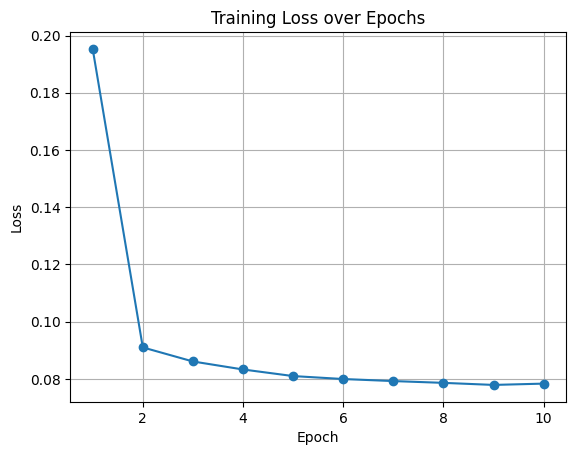

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
num_epochs = 10

train_losses = []

lstm_model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader_lstm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    train_losses.append(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

# Plot the loss curve
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [32]:
# Evaluation on the test set
lstm_model.eval()
total_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader_lstm:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Loss: {total_loss/total:.4f}, Test Accuracy: {correct/total:.4f}')

Test Loss: 0.1164, Test Accuracy: 0.9400


### Model 11: Word GloVe on Bidirectional-LSTM

In [34]:
class BiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, output_dim=6):
        super().__init__()

        dropout = 0.2
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32), 
            freeze=False  # Allow finetuning of embedding
        )

        self.dropout0 = nn.Dropout(dropout)

        self.bilstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            num_layers=1, 
            bidirectional=True, 
            batch_first=True,
        )

        self.l1 = nn.Linear(hidden_dim * 2, 1024)  # *2 for bidirectional
        self.dropout1 = nn.Dropout(dropout)

        self.l2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(dropout)

        self.l3 = nn.Linear(1024, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # shape (batch_size, seq_len, embedding_dim)

        x = self.dropout0(x)  

        x, (_h, _c) = self.bilstm(x)
        h_forward = _h[-2, :, :]  # Last hidden state of the forward LSTM
        h_backward = _h[-1, :, :] # Last hidden state of the backward LSTM
        x = torch.cat((h_forward, h_backward), dim=1)

        x = self.l1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.l3(x)
        return x

In [35]:
bilstm = BiLSTM(embedding_matrix).to(device)

In [36]:
summary(bilstm, input_size=(128, max_len), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [128, 6]                  --
├─Embedding: 1-1                         [128, 70, 300]            20,340,600
├─Dropout: 1-2                           [128, 70, 300]            --
├─LSTM: 1-3                              [128, 70, 256]            440,320
├─Linear: 1-4                            [128, 1024]               263,168
├─Dropout: 1-5                           [128, 1024]               --
├─Linear: 1-6                            [128, 1024]               1,049,600
├─Dropout: 1-7                           [128, 1024]               --
├─Linear: 1-8                            [128, 6]                  6,150
Total params: 22,099,838
Trainable params: 22,099,838
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 6.72
Input size (MB): 0.07
Forward/backward pass size (MB): 41.96
Params size (MB): 88.40
Estimated Total Size (MB): 130.43

 10%|█         | 1/10 [00:13<02:03, 13.73s/it]

Epoch [1/10], Loss: 0.1971, Accuracy: 0.9090


 20%|██        | 2/10 [00:27<01:49, 13.67s/it]

Epoch [2/10], Loss: 0.0914, Accuracy: 0.9417


 30%|███       | 3/10 [00:40<01:35, 13.62s/it]

Epoch [3/10], Loss: 0.0870, Accuracy: 0.9422


 40%|████      | 4/10 [00:54<01:21, 13.54s/it]

Epoch [4/10], Loss: 0.0834, Accuracy: 0.9434


 50%|█████     | 5/10 [01:07<01:06, 13.40s/it]

Epoch [5/10], Loss: 0.0818, Accuracy: 0.9439


 60%|██████    | 6/10 [01:20<00:53, 13.30s/it]

Epoch [6/10], Loss: 0.0802, Accuracy: 0.9441


 70%|███████   | 7/10 [01:33<00:39, 13.27s/it]

Epoch [7/10], Loss: 0.0790, Accuracy: 0.9448


 80%|████████  | 8/10 [01:47<00:26, 13.26s/it]

Epoch [8/10], Loss: 0.0791, Accuracy: 0.9446


 90%|█████████ | 9/10 [02:00<00:13, 13.31s/it]

Epoch [9/10], Loss: 0.0781, Accuracy: 0.9451


100%|██████████| 10/10 [02:14<00:00, 13.41s/it]

Epoch [10/10], Loss: 0.0778, Accuracy: 0.9449


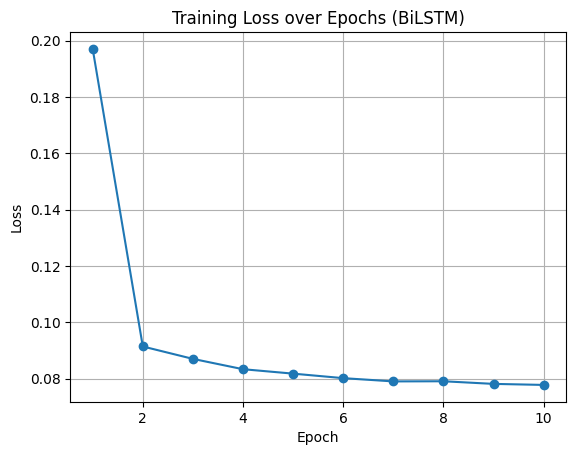

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm.parameters(), lr=0.001)
num_epochs = 10
train_losses_bilstm = []

bilstm.train()

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader_lstm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = bilstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    train_losses_bilstm.append(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

# Plot the loss curve for BiLSTM
plt.plot(range(1, num_epochs+1), train_losses_bilstm, marker='o')
plt.title('Training Loss over Epochs (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [38]:
# Evaluation on the test set for BiLSTM
bilstm.eval()

total_loss = 0
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_lstm:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = bilstm(inputs)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Test Loss (BiLSTM): {total_loss/total:.4f}, Test Accuracy (BiLSTM): {correct/total:.4f}')

Test Loss (BiLSTM): 0.1221, Test Accuracy (BiLSTM): 0.9398


In [39]:
all_labels

[np.int64(1),
 np.int64(2),
 np.int64(4),
 np.int64(1),
 np.int64(4),
 np.int64(3),
 np.int64(4),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(3),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(2),
 np.int64(4),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(1),
 np.int64(0),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(4),
 np.int64(4),
 np.int64(3),
 np.int64(0),
 np.int64(0),
 np.int64(4),
 np.int64(2),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(3),
 np.int64(2),
 np.int64(1),
 np.int64(0),
 np.int64(3),
 np.int64(1),
 np.int64(5),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(0),
 np.int64(1),
 np.int64(4),
 np.int64(4),
 np.int64(4),
 np.int64(1),
 np.int64(3),
 np.int64(3),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.in

In [40]:
# classification report, confusion matrix
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
print(classification_report(all_labels, all_preds, target_names=[emotion(i) for i in range(n_classes)]))

              precision    recall  f1-score   support

     sadness       0.98      0.97      0.98     24238
         joy       0.99      0.92      0.95     28214
        love       0.77      1.00      0.87      6911
       anger       0.91      0.99      0.95     11463
        fear       0.99      0.81      0.89      9542
    surprise       0.77      0.92      0.83      2994

    accuracy                           0.94     83362
   macro avg       0.90      0.93      0.91     83362
weighted avg       0.95      0.94      0.94     83362



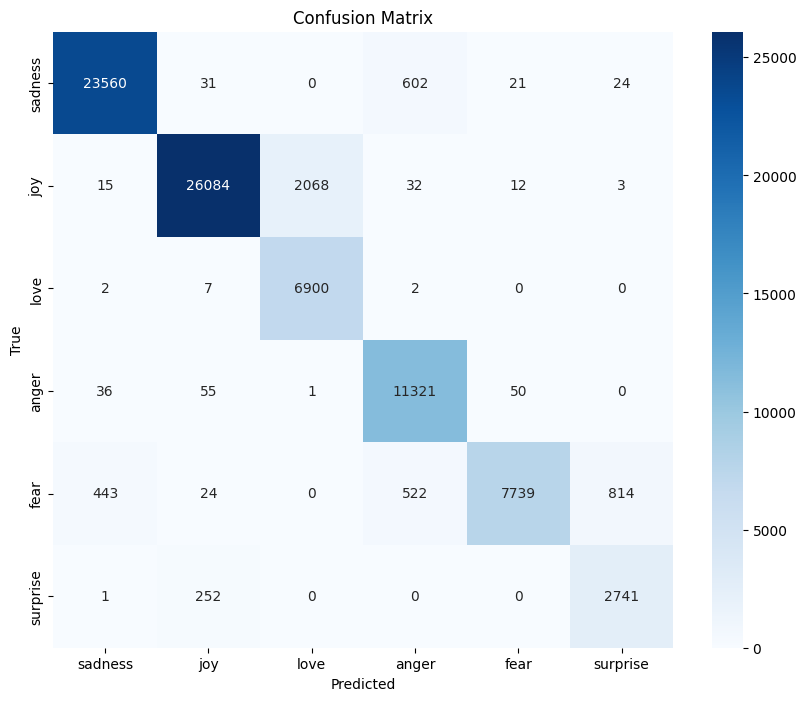

In [41]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[emotion(i) for i in range(n_classes)], yticklabels=[emotion(i) for i in range(n_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Model 12: Word GloVe on 2-layer GRU

In [42]:
class GRU2(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, output_dim=6):
        super().__init__()

        dropout = 0.2
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32), 
            freeze=False  # Allow finetuning of embedding
        )

        self.dropout0 = nn.Dropout(dropout)

        self.gru = nn.GRU(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            num_layers=2, 
            batch_first=True,
            dropout=dropout,  # Dropout after GRU layer
        )

        self.l1 = nn.Linear(hidden_dim, 1024)  # *2 for bidirectional
        self.dropout1 = nn.Dropout(dropout)

        self.l2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(dropout)

        self.l3 = nn.Linear(1024, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # shape (batch_size, seq_len, embedding_dim)

        x = self.dropout0(x)  

        x, _ = self.gru(x)
        x = x[:, -1, :]

        x = self.l1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.l3(x)
        return x

In [43]:
gru2 = GRU2(embedding_matrix).to(device)

In [44]:
summary(gru2, input_size=(128, max_len), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRU2                                     [128, 6]                  --
├─Embedding: 1-1                         [128, 70, 300]            20,340,600
├─Dropout: 1-2                           [128, 70, 300]            --
├─GRU: 1-3                               [128, 70, 128]            264,192
├─Linear: 1-4                            [128, 1024]               132,096
├─Dropout: 1-5                           [128, 1024]               --
├─Linear: 1-6                            [128, 1024]               1,049,600
├─Dropout: 1-7                           [128, 1024]               --
├─Linear: 1-8                            [128, 6]                  6,150
Total params: 21,792,638
Trainable params: 21,792,638
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 5.12
Input size (MB): 0.07
Forward/backward pass size (MB): 32.78
Params size (MB): 87.17
Estimated Total Size (MB): 120.02

 10%|█         | 1/10 [00:13<02:00, 13.40s/it]

Epoch [1/10], Loss: 0.1667, Accuracy: 0.9182


 20%|██        | 2/10 [00:26<01:47, 13.49s/it]

Epoch [2/10], Loss: 0.0915, Accuracy: 0.9413


 30%|███       | 3/10 [00:40<01:34, 13.47s/it]

Epoch [3/10], Loss: 0.0875, Accuracy: 0.9425


 40%|████      | 4/10 [00:53<01:21, 13.50s/it]

Epoch [4/10], Loss: 0.0842, Accuracy: 0.9430


 50%|█████     | 5/10 [01:07<01:07, 13.48s/it]

Epoch [5/10], Loss: 0.0827, Accuracy: 0.9443


 60%|██████    | 6/10 [01:20<00:53, 13.29s/it]

Epoch [6/10], Loss: 0.0809, Accuracy: 0.9449


 70%|███████   | 7/10 [01:33<00:40, 13.37s/it]

Epoch [7/10], Loss: 0.0800, Accuracy: 0.9445


 80%|████████  | 8/10 [01:47<00:26, 13.31s/it]

Epoch [8/10], Loss: 0.0796, Accuracy: 0.9449


 90%|█████████ | 9/10 [02:00<00:13, 13.21s/it]

Epoch [9/10], Loss: 0.0794, Accuracy: 0.9448


100%|██████████| 10/10 [02:12<00:00, 13.30s/it]

Epoch [10/10], Loss: 0.0788, Accuracy: 0.9448


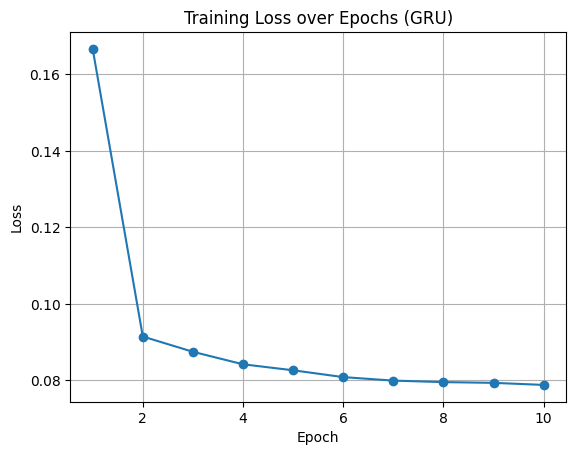

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru2.parameters(), lr=0.001)

num_epochs = 10

train_losses_gru2 = []

gru2.train()

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader_lstm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = gru2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    train_losses_gru2.append(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

# Plot the loss curve for GRU
plt.plot(range(1, num_epochs+1), train_losses_gru2, marker='o')
plt.title('Training Loss over Epochs (GRU)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [46]:
# Evaluation on the test set for GRU
gru2.eval()
total_loss = 0
correct = 0
total = 0
all_preds_gru = []
all_labels_gru = []
with torch.no_grad():
    for inputs, labels in test_loader_lstm:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = gru2(inputs)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds_gru.extend(predicted.cpu().numpy())
        all_labels_gru.extend(labels.cpu().numpy())

print(f'Test Loss (GRU): {total_loss/total:.4f}, Test Accuracy (GRU): {correct/total:.4f}')

Test Loss (GRU): 0.1064, Test Accuracy (GRU): 0.9403


In [47]:
all_labels_gru = np.array(all_labels_gru)
all_preds_gru = np.array(all_preds_gru)
print(classification_report(all_labels_gru, all_preds_gru, target_names=[emotion(i) for i in range(n_classes)]))

              precision    recall  f1-score   support

     sadness       0.98      0.97      0.98     24238
         joy       0.92      1.00      0.96     28214
        love       1.00      0.70      0.83      6911
       anger       0.91      0.99      0.95     11463
        fear       0.91      0.90      0.90      9542
    surprise       1.00      0.64      0.78      2994

    accuracy                           0.94     83362
   macro avg       0.95      0.87      0.90     83362
weighted avg       0.94      0.94      0.94     83362



# Final Experiment

In [82]:
"best_models = [lgr, nb5_best, nb6_best, lstm_model, bilstm, gru2]"

def predict(model, sentence):
    if isinstance(model, (LogisticRegression,MultinomialNB)):
        # we need to transform the sentence to TF-IDF
        sentence_tfidf = tfidfv.transform([sentence])
        sentence_tfidf_selected = selector.transform(sentence_tfidf)
        probabilities = model.predict_proba(sentence_tfidf_selected)[0]
        return probabilities
    elif isinstance(model, (LSTM, BiLSTM, GRU2)):
        # we need to transform the words to GloVe sequences
        seq = token.texts_to_sequences([sentence])
        seq = sequence.pad_sequences(seq, maxlen=max_len)
        seq_tensor = torch.tensor(seq, dtype=torch.long).to(device)
        with torch.no_grad():
            probabilities = model(seq_tensor)
        probabilities = F.softmax(probabilities, dim=1).cpu().numpy()[0]
        return probabilities

In [92]:
s = "Do not do that, that is not nice"

emotions(predict(lgr, s))
print()
emotions(predict(lstm_model, s))
print()
emotions(predict(bilstm, s))

Probabilities:
sadness: 0.2221
joy: 0.4352
love: 0.0709
anger: 0.1705
fear: 0.0822
surprise: 0.0190

Probabilities:
sadness: 0.3088
joy: 0.0099
love: 0.0000
anger: 0.6480
fear: 0.0334
surprise: 0.0000

Probabilities:
sadness: 0.0013
joy: 0.0239
love: 0.0000
anger: 0.9571
fear: 0.0177
surprise: 0.0000


### Conclusion: 

LSTMs and logistic regression, naive bayes might have similar accuracy

but they should have different multiclass logloss

LSTMs can capture context
